In [1]:
import pickle

class BlueReservoir:

    def __init__(self, b, smax,c, s0=0) -> None:
        self.b = b
        self.smax = smax
        self.s = s0
        self.c = c
    
    def __call__(self, p,ep):
        return self.forward(p,ep)

    def forward(self,p,ep):
        ep = round(ep*(ep>0), 4)
        q,e = 0.0, ep
        smax, b, s,c = self.smax, self.b, self.s, self.c
        sbar = s/smax
        me = p-ep
        a = me/smax
        if me >= 0:
            q = me + s - smax
            temp = (1-sbar)**(1/(b+1)) - me/((b+1)*smax)
            if temp > 0:
                temp = smax*(temp**(b+1))
                q += temp
                temp = round(temp,4)
                q = round(q,4)
                self.s = smax - temp
            else:
                q = round(q,4)
                self.s = smax
                
        else:
            e = p + s
            temp = a*(1-c)+sbar**(1-c)
            if temp > 0:
                e-=smax*temp**(1/(1-c))
            e = round(e,4)
            self.s += p-e
        self.s = round(self.s,4)
        assert e >= 0
        assert self.s >= 0
        assert self.s <= smax
        assert q >= 0
        return q,e

def generate_data(name,b,smax,c):
    pkl_path = '../../data/pet.pkl'
    with open(pkl_path, 'rb') as f:
        pets = pickle.load(f)[name]['PET(mm/d)'].tolist()

    file_path = "../../data/fake/basin_mean_forcing/daymet/02/"+name+"_lump_cida_forcing_leap.txt"
    precip = []
    dates = []
    with open(file_path) as f:
        for _ in range(5):
            l = f.readline()
        while l:
            l = l.split('\t')
            precip.append(float(l[2]))
            dates.append(l[0])
            l = f.readline()
    network = BlueReservoir(b,smax,c)
    with open("../../data/fake/usgs_streamflow/02/"+name+"_streamflow_qc.txt",'w') as f:
        for d,p,e in zip(dates, precip,pets):
            f.write(' '.join([name, d[:-3], str(network(p,e)[0]), 'A']))
            f.write('\n')

generate_data('01333000',0.7,50.0,0.5)
generate_data('01439500',2.0,20.0,0.4)

In [28]:
import sys
sys.path.append('..')  # Add the parent folder to the sys.path
sys.path.append('../..')  # Add the parent of the parent folder to the sys.path
from pathlib import Path
from neuralhydrology.nh_run import start_run

In [41]:

start_run(config_file=Path("example4.yml", gpu=-1))

2024-02-16 10:22:04,938: Logging to runs\dev\run_1602_102204\output.log initialized.
2024-02-16 10:22:04,939: ### Folder structure created at runs\dev\run_1602_102204
2024-02-16 10:22:04,940: ### Run configurations for run
2024-02-16 10:22:04,940: experiment_name: None
2024-02-16 10:22:04,941: run_dir: runs\dev\run_1602_102204
2024-02-16 10:22:04,942: train_basin_file: 1_basin_list.txt
2024-02-16 10:22:04,944: validation_basin_file: 1_basin_list.txt
2024-02-16 10:22:04,944: test_basin_file: 1_basin_list.txt
2024-02-16 10:22:04,946: train_start_date: 2006-10-01 00:00:00
2024-02-16 10:22:04,946: train_end_date: 2008-09-30 00:00:00
2024-02-16 10:22:04,947: validation_start_date: 2002-10-01 00:00:00
2024-02-16 10:22:04,948: validation_end_date: 2004-09-30 00:00:00
2024-02-16 10:22:04,949: test_start_date: 1998-10-01 00:00:00
2024-02-16 10:22:04,950: test_end_date: 2000-09-30 00:00:00
2024-02-16 10:22:04,950: per_basin_train_periods_file: None
2024-02-16 10:22:04,950: per_basin_validation_p

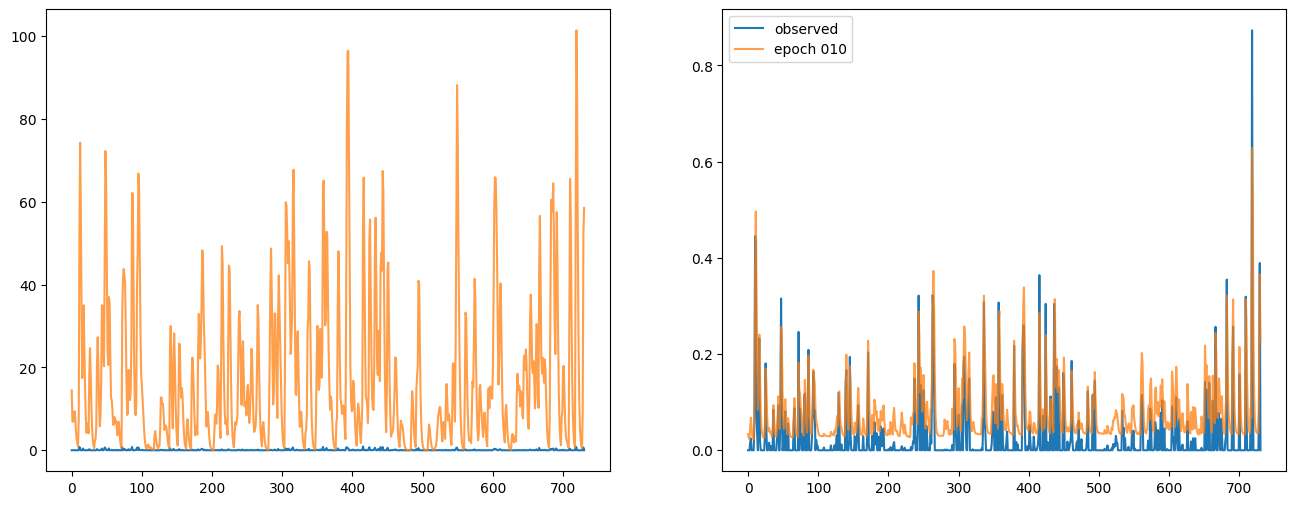

NSE: 0.202
MSE: 0.004
RMSE: 0.064
KGE: -0.746
Alpha-NSE: 0.959
Beta-KGE: 2.739
Beta-NSE: 0.712
Pearson-r: 0.849
FHV: -0.898
FMS: -90.148
FLV: -8519358825.684
Peak-Timing: 0.333
Peak-MAPE: 26.472


In [43]:
run_dir = "runs/dev/run_1602_102204" #CHANGE IT

import pickle
import matplotlib.pyplot as plt
from neuralhydrology.evaluation import metrics

nb_epochs = 10
#basins = ['01439500','01333000']
basins = ['01333000','01439500']
nb_epochs = str(nb_epochs)
nb_epochs = (3-len(nb_epochs))*'0'+nb_epochs

fig, axs = plt.subplots(1, 2,figsize=(16, 6)) 
with open(run_dir + "/validation/model_epoch"+nb_epochs+"/validation_results.p", "rb") as fp:
    results = pickle.load(fp)
    for i,basin in enumerate(basins):
        qsim = results[basin]['1D']['xr']['QObs(mm/d)_sim']
        qobs = results[basin]['1D']['xr']['QObs(mm/d)_obs']
        axs[i].plot(qobs, label='observed')
        axs[i].plot(qsim,label="epoch "+nb_epochs, alpha = 0.75)
plt.legend()
plt.show()

metric_values = metrics.calculate_all_metrics(qobs.isel(time_step=-1),
                                              qsim.isel(time_step=-1))
for key, val in metric_values.items():
    print(f"{key}: {val:.3f}")